In [227]:
import numpy as np
from typing import Tuple
from matplotlib import pyplot as plt
from scipy.stats import norm
import pandas as pd
from tqdm import tqdm

# Black and Schole & Heston asset modelisation

## Black and Schole

$$dS_t = r S_t dt + \sigma S_t dW_t$$

$r$ : Risk-free interest rate

$\sigma$ : Volatility

$W_t$ : Brownian Motion

In particular we can derive that $S_t = S_0 e^{(r - \frac{\sigma^2}{2})t + \sigma W_t}$

## Heston

$$dS_t = r S_t dt + \sqrt{\nu_t} S_t dW_t^S$$

$$d\nu_t = \kappa (\theta - \nu_t)dt + \xi \sqrt{\nu_t} dW_t^{\nu}$$

$$<W_t^S, W_t^{\nu}> = \rho$$

$\kappa$ : Mean reversion rate

$\theta$ : Long-term variance

$\xi$ : Volatility of variance

$W_t^S , W_t^{\nu}$ : corrolated Brownian motions

$\rho$ : Correlation between asset and variance Brownian motions


In [228]:
class asset:
    """
    Simulates asset paths under Black-Scholes and Heston models.

    Parameters:
        S0 (float): Initial asset price.
        T (float): Maturity in years.
        r (float): Risk-free interest rate.
        sigma (float): Volatility for Black-Scholes.
        kappa (float): Mean reversion rate in the Heston model.
        theta (float): Long-term variance in the Heston model.
        xi (float): Volatility of variance in the Heston model.
        v0 (float): Initial variance in the Heston model.
        rho (float): Correlation between asset and variance Brownian motions.

    Methods:
        brownian_path (np.ndarray, float) -> Tuple[np.ndarray, np.ndarray]:
            Generates standard Brownian paths based on input noise and time steps.

        black_and_scholes_paths (int, int) -> np.ndarray:
            Simulates Black-Scholes paths for the asset over given steps and simulations.

        asian_black_and_scholes_paths (int, int) -> np.ndarray:
            Computes average Black-Scholes paths for Asian option pricing.

        heston_asset_paths (int, int) -> np.ndarray:
            Simulates asset paths under the Heston model for given steps and simulations.

        asian_heston_asset_paths (int, int) -> np.ndarray:
            Computes average Heston paths for Asian option pricing.

        get_paths (int, str, str, int, int) -> np.ndarray:
            Retrieves asset paths based on the specified model (Black-Scholes or Heston) and option type (European or Asian).
    """

    def __init__(self, S0 = 100, T = 1, r = 0.05, sigma = 0.3, kappa = 1.0, theta = 0.04, xi = 0.1, v0 = 0.04, rho = -0.7):
        self.S0 = S0
        self.T = T
        self.r = r
        self.sigma = sigma
        self.kappa = kappa
        self.theta = theta
        self.xi = xi
        self.v0 = v0
        self.rho = rho

    def brownian_paths(self, noise, delta):
        """
        Generates Brownian paths based on input noise and time increments.

        Parameters:
            noise (np.ndarray): Random noise used to generate Brownian paths.
            delta (float): Time increment.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Cumulative Brownian paths and increments.
        """
        N_Brownian, M_Brownian = noise.shape
        tn = (np.arange(N_Brownian) * delta)[:, None]
        dB = np.zeros((N_Brownian, M_Brownian))
        dB[1:] = np.sqrt(tn[1:] - tn[:-1]) * noise[1:]
        return np.cumsum(dB, axis=0), dB

    def black_and_scholes_paths(self, n_steps = 252, n_simulations = 1000, end_value = False):
        """
        Simulates asset paths under the Black-Scholes model.

        Parameters:
            end_value (boolean): Choose to only return the end value of the process
            n_steps (int): Number of time steps.
            n_simulations (int): Number of simulations.

        Returns:
            np.ndarray: Simulated asset paths under Black-Scholes model.
        """
        if end_value:
          W = np.random.normal(0, 1, n_simulations)
          ST = self.S0 * np.exp((self.r - self.sigma ** 2 / 2) * self.T + self.sigma * np.sqrt(self.T) * W)
          return ST

        noise = np.random.normal(0, 1, (n_steps, n_simulations))
        delta = self.T / n_steps
        W, _ = self.brownian_paths(noise, delta)
        tn = (np.arange(n_steps) * delta)[:, None]
        S = self.S0 * np.exp((self.r - self.sigma ** 2 / 2) * tn + self.sigma * W)
        return S

    def asian_black_and_scholes_paths(self, n_steps = 252, n_simulations = 1000):
        """
        Computes the average Black-Scholes paths for Asian option pricing.

        Parameters:
            n_steps (int): Number of time steps.
            n_simulations (int): Number of simulations.

        Returns:
            np.ndarray: Averaged asset paths for Asian options under Black-Scholes.
        """
        S = self.black_and_scholes_paths(n_steps, n_simulations)
        return np.mean(S, axis=0)

    def heston_asset_paths(self, n_steps = 252, n_simulations = 1000, end_value = False):
        """
        Simulates asset paths under the Heston model.

        Parameters:
            end_value (boolean): Choose to only return the end value of the process
            n_steps (int): Number of time steps.
            n_simulations (int): Number of simulations.

        Returns:
            np.ndarray: Simulated asset paths under the Heston model.
        """
        delta = self.T / n_steps
        noise = np.random.normal(0, 1, (n_steps, n_simulations))
        noise_S = np.random.normal(0, 1, (n_steps, n_simulations))
        noise_V = self.rho * noise_S + np.sqrt(1 - self.rho ** 2) * noise
        W_S, dW_S = self.brownian_paths(noise_S, delta)
        W_V, dW_V = self.brownian_paths(noise_V, delta)

        S = np.zeros((n_steps, n_simulations))
        V = np.zeros((n_steps, n_simulations))
        S[0] = self.S0
        V[0] = self.v0

        for t in range(1, n_steps):
            V[t] = np.maximum(V[t - 1] + self.kappa * (self.theta - V[t - 1]) * delta + self.xi * np.sqrt(V[t - 1]) * dW_V[t - 1], 0)
            S[t] = S[t - 1] * np.exp((self.r - 0.5 * V[t - 1]) * delta + np.sqrt(V[t - 1]) * dW_S[t - 1])

        if end_value:
          return S[-1]

        return S

    def asian_heston_asset_paths(self, n_steps = 252, n_simulations = 1000):
        """
        Computes the average Heston paths for Asian option pricing.

        Parameters:
            n_steps (int): Number of time steps.
            n_simulations (int): Number of simulations.

        Returns:
            np.ndarray: Averaged asset paths for Asian options under the Heston model.
        """
        S = self.heston_asset_paths(n_steps, n_simulations)
        return np.mean(S, axis=0)

    def get_paths(self, model = 'BS', option_type = 'asian', n_steps = 252, n_simulations = 1000):
        """
        Retrieves paths based on specified model (Black-Scholes or Heston) and option type (European or Asian).

        Parameters:
            t (int): Time index for retrieving the asset path. Default is -1 (final time step).
            model (str): Model type ('BS' for Black-Scholes, 'heston' for Heston).
            option_type (str): Option type ('european' or 'asian').
            n_steps (int): Number of time steps.
            n_simulations (int): Number of simulations.

        Returns:
            np.ndarray: Asset paths for the specified model and option type.
        """
        if model == 'BS':
            if option_type == 'european':
                return self.black_and_scholes_paths(n_steps = n_steps, n_simulations = n_simulations, end_value = True)
            elif option_type == 'asian':
                return self.asian_black_and_scholes_paths(n_steps = n_steps, n_simulations = n_simulations)
            else:
                raise ValueError("Incorrect option type. Choose either 'european' or 'asian'.")

        elif model == 'heston':
            if option_type == 'european':
                return self.heston_asset_paths(n_steps = n_steps, n_simulations = n_simulations, end_value = True)
            elif option_type == 'asian':
                return self.asian_heston_asset_paths(n_steps = n_steps, n_simulations = n_simulations)
            else:
                raise ValueError("Incorrect option type. Choose either 'european' or 'asian'.")

        else:
            raise ValueError("Incorrect model. Choose either 'BS' or 'heston'.")


In [229]:
def confidence_interval(data: np.ndarray) -> Tuple[float, float]:
    """
    Calculates the 95% confidence interval for a dataset.

    Parameters:
        data (np.ndarray): Array of data points.

    Returns:
        Tuple[float, float]: Mean and half-width of the 95% confidence interval.
    """
    mean = np.mean(data)
    std_error = np.std(data) / np.sqrt(len(data))
    interval = 1.96 * std_error
    return mean, interval, std_error

In [230]:
def call_price(asset, K = 80, n_steps = 252, n_simulations = 100_000, model = 'BS', option_type = 'european') -> Tuple[float, float]:
    """
    Estimates the price of a call option using a naive Monte Carlo method.

    Parameters:
        asset (asset): The asset instance containing parameters and simulation methods.
        t (int): Time index for retrieving the asset path. Default is -1 (final time step).
        K (float): Strike price of the option.
        n_steps (int): Number of time steps for the simulation.
        n_simulations (int): Number of simulations to run.
        model (str): Model used for asset price simulation ('BS' for Black-Scholes or 'heston').
        option_type (str): Option type ('european' or 'asian').

    Returns:
        Tuple[float, float]: Estimated call option price and 95% confidence interval half-width.
    """
    ST_X = asset.get_paths(model = model,
                           option_type = option_type,
                           n_steps = n_steps,
                           n_simulations = n_simulations
                           )
    discounted_payoff = np.exp(-asset.r * asset.T) * np.maximum(ST_X - K, 0)
    mean, interval, std = confidence_interval(discounted_payoff)

    return mean, interval, std

In [ ]:
def exact_BS_price(asset, K = 80, option = 'call'):
  d1 = (np.log(asset.S0 / K) + (asset.r + asset.sigma ** 2 / 2) * asset.T) / (asset.sigma * np.sqrt(T))
  d2 = d1 - asset.sigma * np.sqrt(T)
  if option == 'call':
    price = asset.S0 * norm.cdf(d1) - K * np.exp(-asset.r * asset.T) * norm.cdf(d2)
  elif option == 'put':
    price = K * np.exp(-asset.r * asset.T) * norm.cdf(-d2) - asset.S0 * norm.cdf(-d1)
  else:
    raise ValueError("Incorrect option. Enter either {call, put}")

  return price

# Call and Put Option Valuation with Monte Carlo Simulations

## Option Definitions

### European options

We define the payoff of a European call option with strike $K$ and maturity $T$ as:

$$
h_T = (S_T - K)_+
$$

and for a European put option:

$$
h_T = (K - S_T)_+.
$$

The **call-put parity relationship** at time $t = 0$ is given by:

$$
\text{Call}_0(K, T) - \text{Put}_0(K, T) = S_0 - K e^{-rT}
$$

Such that:

$$
\text{Call}_0(K, T) = \mathbb{E}\left(\underbrace{e^{-rT} (S_T - K)_+}_{X}\right) = \mathbb{E}\left(\underbrace{e^{-rT} (K - S_T)_+ + S_0 - K e^{-rT}}_{X'}\right)
$$

and we have that $
\mathbb{E}(X) = \mathbb{E}(X') = \text{Call}_0(K, T).
$

### Asian options

We define the payoff of an Asian call option with strike $K$ and maturity $T$ as:

$$
h_T = (\frac{1}{T}\int_0^T S_t dt - K)_+
$$

and for an Asian put option:

$$
h_T = (K - \frac{1}{T}\int_0^T S_t dt)_+.
$$

The **call-put parity relationship** at time $t = 0$ is given by:

$$
\text{Call}_0^{AS}(K, T) - \text{Put}_0^{AS}(K, T) = S_0 \frac{1 - e^{-rT}}{rT} - K e^{-rT}
$$

So, at $t = 0$:

$$
\text{Call}_0(K, T) = \mathbb{E}\left(\underbrace{e^{-rT} (\frac{1}{T}\int_0^T S_t dt - K)_+}_{X}\right) = \mathbb{E}\left(\underbrace{e^{-rT} (K - \frac{1}{T}\int_0^T S_t dt)_+ + S_0 \frac{1 - e^{-rT}}{rT} - K e^{-rT}}_{X'}\right)
$$

and we have that $
\mathbb{E}(X) = \mathbb{E}(X') = \text{Call}_0(K, T).
$

# Variance Reduction

## Antithetic Random Variable Method

Thus we can consider the most naive implementation which is $Call_0(K, T) = \mathbb{E}(\frac{X^{\prime} + X}{2})$

In [231]:
def call_price_antithetic(asset, K = 80, n_steps = 252, n_simulations = 100_000, model = 'BS', option_type = 'european') -> Tuple[float, float]:
    """
    Estimates the price a call option using antithetic Monte Carlo method.

    Parameters:
        asset (asset): The asset instance containing parameters and simulation methods.
        t (int): Time index for retrieving the asset path. Default is -1 (final time step).
        K (float): Strike price of the option.
        n_steps (int): Number of time steps for the simulation.
        n_simulations (int): Number of simulations to run.
        model (str): Model used for asset price simulation ('BS' for Black-Scholes or 'heston').
        option_type (str): Option type ('european' or 'asian').

    Returns:
        Tuple[float, float]: Estimated call option price and 95% confidence interval half-width.
    """
    ST_X = asset.get_paths(model = model,
                           option_type = option_type,
                           n_steps = n_steps,
                           n_simulations = n_simulations
                           )
    ST_X_prime = asset.get_paths(model = model,
                                 option_type = option_type,
                                 n_steps = n_steps,
                                 n_simulations = n_simulations
                                 )

    X = np.exp(-asset.r * asset.T) * np.maximum(ST_X - K, 0)
    if option_type == 'european':
      X_prime = np.exp(-asset.r * asset.T) * np.maximum(K - ST_X_prime, 0) + asset.S0 - np.exp(-asset.r * asset.T) * K
    elif option_type == 'asian':
      X_prime = np.exp(-asset.r * asset.T) * np.maximum(K - ST_X_prime, 0) + asset.S0 * (1 - np.exp(-asset.r * asset.T)) / (asset.r * asset.T) - np.exp(-asset.r * asset.T) * K

    call_price_estimation = (X + X_prime) / 2

    mean, interval, std = confidence_interval(call_price_estimation)

    return mean, interval, std

## Regression based Controle Variate

To improve the efficiency of Monte Carlo simulations, we use a control variate $X^\lambda = X - \lambda \xi$, where $\xi = X - X'$.

The variance of $X^\lambda$ is:

$$
\text{Var}(X^\lambda) = \text{Var}(X) - 2 \lambda \, \text{Cov}(X, \xi) + \lambda^2 \, \text{Var}(\xi)
$$

which is minimized for
$
\lambda = \frac{\text{Cov}(X, \xi)}{\text{Var}(\xi)}.
$

## Naive Control Variate Implementation

Given $N$ simulations, we set
$
(X_N, X_N') \sim (X, X')
$

Define the sample mean of $X$ as
$
\bar{X}_N = \frac{1}{N} \sum_{i=1}^N X_i
$

Estimate $\lambda$ as
$
\hat{\lambda}_N = \frac{\sum_{i=1}^N X_i (X_i - X_i')}{\sum_{i=1}^N (X_i - X_i')^2}
$

Then, compute the control variate-adjusted mean :

$$
\bar{X}_N^\lambda = \bar{X}_N - \hat{\lambda}_N \bar{\xi}_N
$$

This approach improves the estimation by reducing the variance of the simulated call option price.

In [233]:
def call_price_naive(asset, K = 80, n_steps = 252, n_simulations = 100_000, model = 'BS', option_type = 'european') -> Tuple[float, float]:
    """
    Estimates the price of a call option using a naive Monte Carlo method with control variate adjustment.

    Parameters:
        asset (asset): The asset instance containing parameters and simulation methods.
        t (int): Time index for retrieving the asset path. Default is -1 (final time step).
        K (float): Strike price of the option.
        n_steps (int): Number of time steps for the simulation.
        n_simulations (int): Number of simulations to run.
        model (str): Model used for asset price simulation ('BS' for Black-Scholes or 'heston').
        option_type (str): Option type ('european' or 'asian').

    Returns:
        Tuple[float, float]: Estimated call option price and 95% confidence interval half-width.
    """
    ST_X = asset.get_paths(model = model,
                           option_type = option_type,
                           n_steps = n_steps,
                           n_simulations = n_simulations
                           )
    ST_X_prime = asset.get_paths(model = model,
                                 option_type = option_type,
                                 n_steps = n_steps,
                                 n_simulations = n_simulations
                                 )

    X = np.exp(-asset.r * asset.T) * np.maximum(ST_X - K, 0)
    if option_type == 'european':
      X_prime = np.exp(-asset.r * asset.T) * np.maximum(K - ST_X_prime, 0) + asset.S0 - np.exp(-asset.r * asset.T) * K
    elif option_type == 'asian':
      X_prime = np.exp(-asset.r * asset.T) * np.maximum(K - ST_X_prime, 0) + asset.S0 * (1 - np.exp(-asset.r * asset.T)) / (asset.r * asset.T) - np.exp(-asset.r * asset.T) * K

    xi = X - X_prime

    lambda_hat = np.sum(X * xi) / np.sum(xi**2)

    call_price_estimation = X - lambda_hat * xi

    mean, interval, std = confidence_interval(call_price_estimation)

    return mean, interval, std, lambda_hat

## Practitionner Control Variate Implementation

Given $N$ simulations, we set $M \ll N$ and $N^{\prime} = N - M$:

Estimate $\hat{\lambda}_M$ with
$
(X_M, X_M') \sim (X, X')
$

Such that $\hat{\lambda}_M$ independant of $(X_{N^{\prime}}, X_{N^{\prime}}^{\prime})$

Then, compute the control variate-adjusted mean :

$$
\bar{X}_{N^{\prime}}^\lambda = \bar{X}_{N^{\prime}} - \hat{\lambda}_M \bar{\xi}_{N^{\prime}}
$$

In [234]:
def call_price_practitioner(asset, K = 80, n_steps = 252, n_simulations = 100_000, model = 'BS', option_type = 'european') -> Tuple[float, float]:
    """
    Estimates the price of a call option using a two-phase Monte Carlo approach for practitioner-level accuracy.

    Parameters:
        asset (asset): The asset instance containing parameters and simulation methods.
        t (int): Time index for retrieving the asset path. Default is -1 (final time step).
        K (float): Strike price of the option.
        n_steps (int): Number of time steps for the simulation.
        n_simulations (int): Total number of simulations to run.
        model (str): Model used for asset price simulation ('BS' for Black-Scholes or 'heston').
        option_type (str): Option type ('european' or 'asian').

    Returns:
        Tuple[float, float]: Estimated call option price and 95% confidence interval half-width.
    """
    m = int(n_simulations * 0.05)

    # Estimate lambda using 5% of the simulations
    ST_X_lambda = asset.get_paths(model = model,
                                  option_type = option_type,
                                  n_steps = n_steps,
                                  n_simulations = m
                                  )
    ST_X_prime_lambda = asset.get_paths(model = model,
                                        option_type = option_type,
                                        n_steps = n_steps,
                                        n_simulations = m
                                        )

    X_lambda = np.maximum(ST_X_lambda - K, 0)
    if option_type == 'european':
      X_prime_lambda = np.exp(-asset.r * asset.T) * np.maximum(K - ST_X_prime_lambda, 0) + asset.S0 - np.exp(-asset.r * asset.T) * K
    elif option_type == 'asian':
      X_prime_lambda = np.exp(-asset.r * asset.T) * np.maximum(K - ST_X_prime_lambda, 0) + asset.S0 * (1 - np.exp(-asset.r * asset.T)) / (asset.r * asset.T) - np.exp(-asset.r * asset.T) * K

    xi_lambda = X_lambda - X_prime_lambda

    lambda_hat = np.sum(X_lambda * xi_lambda) / np.sum(xi_lambda**2)

    # Estimate call price with (n_simulations - m) simulations using estimated lambda
    ST_X = asset.get_paths(model = model,
                           option_type = option_type,
                           n_steps = n_steps,
                           n_simulations = n_simulations - m
                           )
    ST_X_prime = asset.get_paths(model = model,
                                 option_type = option_type,
                                 n_steps = n_steps,
                                 n_simulations = n_simulations - m
                                 )

    X = np.maximum(ST_X - K, 0)
    if option_type == 'european':
      X_prime = np.exp(-asset.r * asset.T) * np.maximum(K - ST_X_prime, 0) + asset.S0 - np.exp(-asset.r * asset.T) * K
    elif option_type == 'asian':
      X_prime = np.exp(-asset.r * asset.T) * np.maximum(K - ST_X_prime, 0) + asset.S0 * (1 - np.exp(-asset.r * asset.T)) / (asset.r * asset.T) - np.exp(-asset.r * asset.T) * K

    xi = X - X_prime

    call_price_estimation = X - lambda_hat * xi

    mean, interval, std = confidence_interval(call_price_estimation)

    return mean, interval, std, lambda_hat


## Adaptative Control Variate Implementation

We consider $\tilde{X}_k = X_k - \tilde{\lambda}_{k-1} \xi_k$ where $\tilde{\lambda}_k = -k \vee (k \wedge \lambda_k)$ and $\lambda_k = \frac{Cov(\tilde{X}_k, \xi_k)}{Var(\xi_k)}$

Then the estimation is done such that :

$$
\bar{\tilde{X}}_N = \frac{1}{N}\sum_{i=1}^N \tilde{X}_N= \bar{X}_N - \frac{1}{N}\sum_{i=1}^N \tilde{\lambda}_{k-1} \xi_k
$$

In [235]:
def call_price_adaptive(asset, K = 80, n_steps = 252, n_simulations = 100_000, model = 'BS', option_type = 'european') -> Tuple[float, float]:
    """
    Estimates the price of a call option using an adaptive estimator approach.

    Parameters:
        asset (asset): The asset instance containing parameters and simulation methods.
        t (int): Time index for retrieving the asset path. Default is -1 (final time step).
        K (float): Strike price of the option.
        n_steps (int): Number of time steps for the simulation.
        n_simulations (int): Total number of simulations to run.
        model (str): Model used for asset price simulation ('BS' for Black-Scholes or 'heston').
        option_type (str): Option type ('european' or 'asian').

    Returns:
        Tuple[float, float]: Estimated call option price and 95% confidence interval half-width.
    """
    ST_X = asset.get_paths(model = model,
                           option_type = option_type,
                           n_steps = n_steps,
                           n_simulations = n_simulations
                           )
    ST_X_prime = asset.get_paths(model = model,
                                 option_type = option_type,
                                 n_steps = n_steps,
                                 n_simulations = n_simulations
                                 )

    X = np.maximum(ST_X - K, 0)
    if option_type == 'european':
      X_prime = np.exp(-asset.r * asset.T) * np.maximum(K - ST_X_prime, 0) + asset.S0 - np.exp(-asset.r * asset.T) * K
    elif option_type == 'asian':
      X_prime = np.exp(-asset.r * asset.T) * np.maximum(K - ST_X_prime, 0) + asset.S0 * (1 - np.exp(-asset.r * asset.T)) / (asset.r * asset.T) - np.exp(-asset.r * asset.T) * K

    xi = X - X_prime

    lambda_k = np.cumsum(X * xi) / np.cumsum(xi**2)

    k_range = np.arange(1, n_simulations + 1)
    lambda_tilde = np.clip(lambda_k, -k_range, k_range)

    X_tilde = X - lambda_tilde * xi

    call_price_estimation = np.array(X_tilde)

    mean, interval, std = confidence_interval(call_price_estimation)

    return mean, interval, std, lambda_tilde

## Functions to display the results

In [236]:
def compute_call_prices_and_ci(asset, K, n_simulations, model, option_type):
    """
    Computes call prices and confidence intervals for various methods.
    """
    methods = ["Classic", "Antithetic", "Naive", "Practitioner", "Adaptive"]

    call, ci_call, std_call = call_price(asset=asset, K=K, n_simulations=n_simulations, model=model, option_type=option_type)
    call_antithetic, ci_call_antithetic, std_call_antithetic = call_price_antithetic(asset=asset, K=K, n_simulations=n_simulations, model=model, option_type=option_type)
    call_naive, ci_call_naive, std_call_naive, _ = call_price_naive(asset=asset, K=K, n_simulations=n_simulations, model=model, option_type=option_type)
    call_practitioner, ci_call_practitioner, std_call_practitioner, _ = call_price_practitioner(asset=asset, K=K, n_simulations=n_simulations, model=model, option_type=option_type)
    call_adaptative, ci_call_adaptative, std_call_adaptative, _ = call_price_adaptive(asset=asset, K=K, n_simulations=n_simulations, model=model, option_type=option_type)

    prices = [call, call_antithetic, call_naive, call_practitioner, call_adaptative]
    confidence_intervals = [ci_call, ci_call_antithetic, ci_call_naive, ci_call_practitioner, ci_call_adaptative]
    std = [std_call, std_call_antithetic, std_call_naive, std_call_practitioner, std_call_adaptative]

    return methods, prices, confidence_intervals, std

def display_results_as_dataframe(methods, prices, confidence_intervals):
    """
    Displays call prices and confidence intervals as a pandas DataFrame.
    """
    data = {
        "Method": methods,
        "Price": prices,
        "Confidence Interval": confidence_intervals
    }
    df = pd.DataFrame(data)

    display(df)

def plot_call_price_error(titles, prices, true_price):
    """
    Plots the error in call prices.

    Parameters:
    - titles (list of str): Labels for the methods.
    - prices (list of float): Prices estimated by each method.
    - true_price (float): The true price of the option for error calculation.
    """
    errors = [np.abs(true_price - price) for price in prices]

    plt.figure(figsize=(6, 5))
    plt.bar(titles, errors, edgecolor='black')
    plt.title('Error in Call Option Prices')
    plt.ylabel('Error')
    plt.xlabel('Methods')

    plt.tight_layout()
    plt.show()

def plot_call_price_variance(titles, CI):
    """
    Plots the variance of call prices.

    Parameters:
    - titles (list of str): Labels for the methods.
    - CI (list of float): Confidence intervals for each method (representing variance).
    """
    plt.figure(figsize=(6, 5))
    plt.bar(titles, CI, edgecolor='black')
    plt.title('Variance of Call Option Prices')
    plt.ylabel('Variance')
    plt.xlabel('Methods')

    plt.tight_layout()
    plt.show()

def plot_call_and_lambda_vs_K(asset, n_simulations, model, option_type, K_min, K_max, num_points):
    """
    Computes call prices and lambda values for a range of strike prices and plots the results.

    Parameters:
    - K_min (float): Minimum strike price for the range.
    - K_max (float): Maximum strike price for the range.
    - num_points (int): Number of points for the K_values.
    """
    call_K, lambda_K = [], []
    K_values = np.linspace(K_min, K_max, num_points)

    for K_ in tqdm(K_values):
        call, ci_call, _, lambda_ = call_price_naive(asset=asset,
                                                     K=K_,
                                                     n_simulations=n_simulations,
                                                     model=model,
                                                     option_type=option_type)
        call_K.append(call)
        lambda_K.append(lambda_)

    plt.plot(K_values, call_K, 'go--', label='Call Price')
    plt.xlabel("Strike Price (K)")
    plt.ylabel("Option Price")
    plt.title(f"{option_type.capitalize()} Call Option Price {model} vs. Strike Price")
    plt.legend()
    plt.show()

    plt.plot(K_values, lambda_K, 'go--', label='Lambda')
    plt.xlabel("Strike Price (K)")
    plt.ylabel("Lambda(K)")
    plt.title(f"Variate Control {option_type.capitalize()} Call {model} vs. Strike Price")
    plt.legend()
    plt.show()

## European options with Black and Schole model

In [237]:
# Parameters
S0 = 100          # Initial asset price
K = 80            # Strike price
T = 1             # Maturity in years
r = 0.05          # Risk-free rate
sigma = 0.3       # Volatility
n_simulations = 100_000  # Number of Monte Carlo simulations

asset_ = asset(S0 = S0,
               T = T,
               r = r,
               sigma = sigma
               )

In [238]:
methods, prices, confidence_intervals, std = compute_call_prices_and_ci(asset=asset_, K=K, n_simulations=n_simulations, model='BS', option_type='european')
display_results_as_dataframe(methods, prices, confidence_intervals)

,Method,Price,Confidence Interval
0,Classic,26.430697,0.172053
1,Antithetic,26.416234,0.087698
2,Naive,26.492985,0.038105
3,Practitioner,26.453390,0.039496
4,Adaptive,26.474278,0.038685


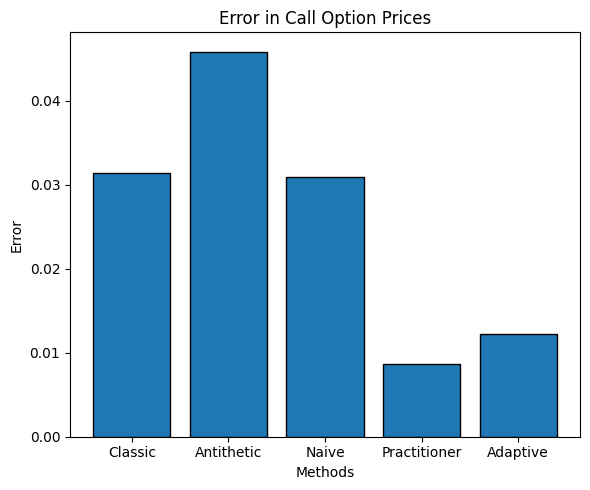

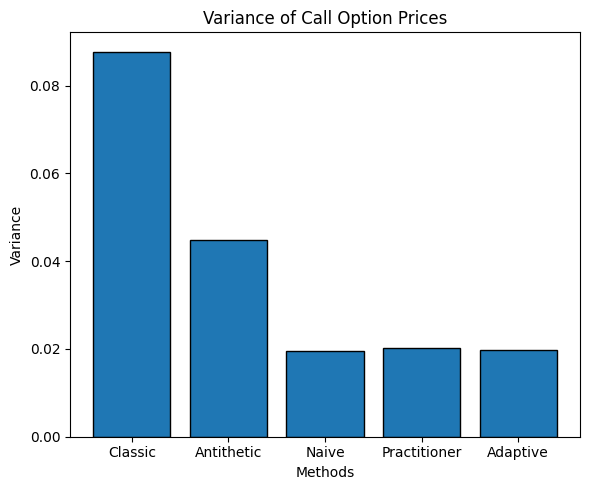

In [239]:
true_price = exact_BS_price(asset_, K)

plot_call_price_error(methods, prices, true_price)
plot_call_price_variance(methods, std)

100%|██████████| 30/30 [00:00<00:00, 57.89it/s]


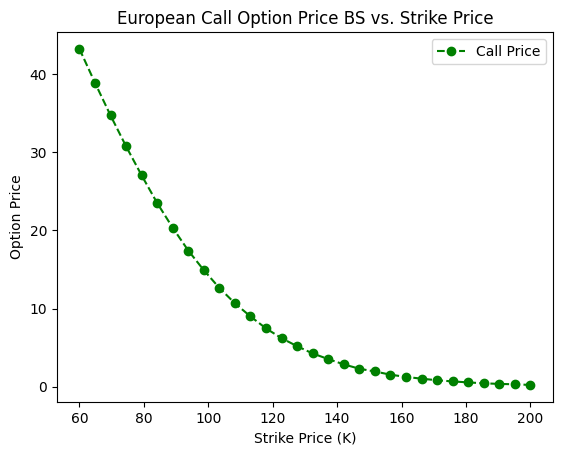

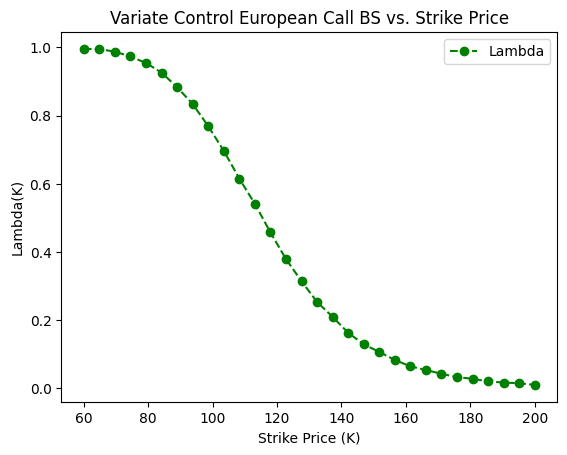

In [240]:
plot_call_and_lambda_vs_K(asset=asset_,
                          n_simulations=n_simulations,
                          model='BS',
                          option_type='european',
                          K_min=60,
                          K_max=200,
                          num_points=30)

## Asian options with Black and Schole model

In [ ]:
methods, prices, confidence_intervals, std = compute_call_prices_and_ci(asset=asset_, K=K, n_simulations=n_simulations, model='BS', option_type='asian')
display_results_as_dataframe(methods, prices, confidence_intervals)

,Method,Price,Confidence Interval
0,Classic,21.876422,0.102172
1,Antithetic,21.927910,0.051298
2,Naive,21.895330,0.012007
3,Practitioner,21.843054,0.015015
4,Adaptive,21.798804,0.015432


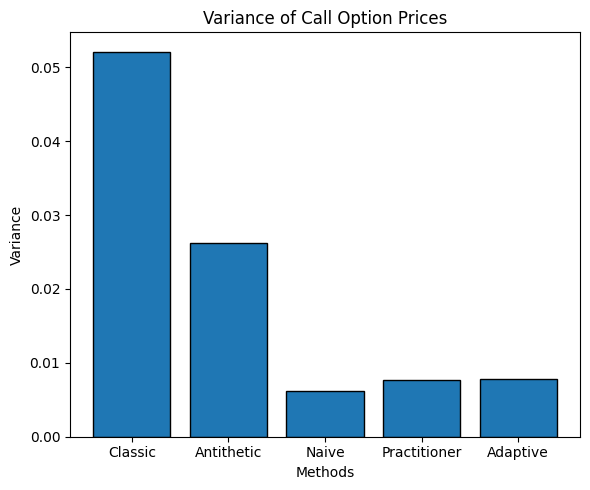

In [ ]:
plot_call_price_variance(methods, std)

100%|██████████| 30/30 [01:53<00:00,  3.77s/it]


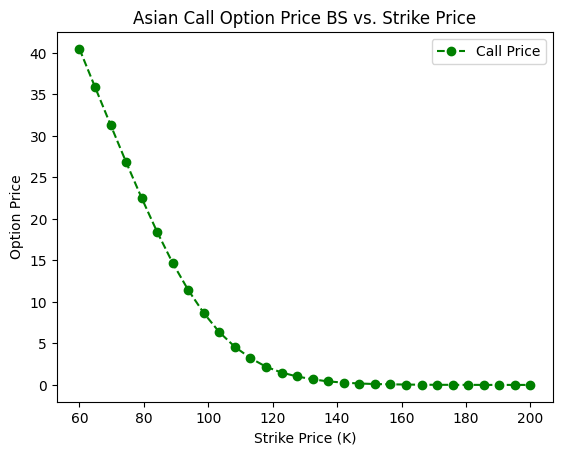

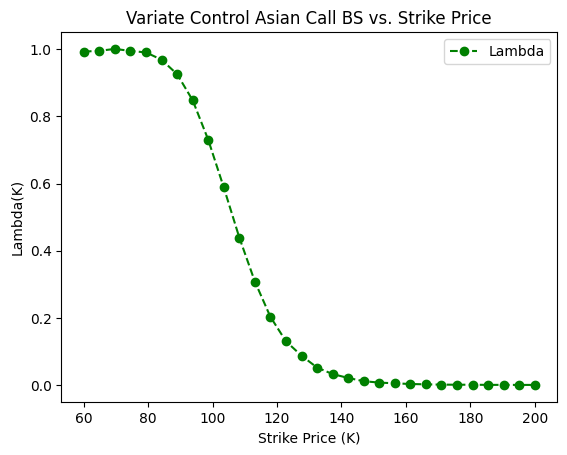

In [ ]:
plot_call_and_lambda_vs_K(asset=asset_,
                          n_simulations=n_simulations,
                          model='BS',
                          option_type='asian',
                          K_min=60,
                          K_max=200,
                          num_points=30)

## European options with Heston model

In [ ]:
# Parameters
S0 = 100          # Initial asset price
K = 80            # Strike price
T = 1             # Maturity in years
r = 0.05          # Risk-free rate
kappa = 2         # Reversion speed
theta = 0.01      # Long term variance mean
xi = 0.2          # Volatility of volatility
v0 = 0.1          # Initial Variance
rho = 0.5         # Brownian correlation
n_simulations = 100_000
n_steps = 252     # time steps

asset_ = asset(S0 = S0,
               T = T,
               r = r,
               kappa = kappa,
               theta = theta,
               xi = xi,
               v0 = v0,
               rho = rho
               )

In [ ]:
methods, prices, confidence_intervals, std = compute_call_prices_and_ci(asset=asset_, K=K, n_simulations=n_simulations, model='heston', option_type='european')
display_results_as_dataframe(methods, prices, confidence_intervals)

,Method,Price,Confidence Interval
0,Classic,24.642928,0.137668
1,Antithetic,24.606214,0.069032
2,Naive,24.605007,0.016020
3,Practitioner,24.546143,0.018929
4,Adaptive,24.560252,0.017981


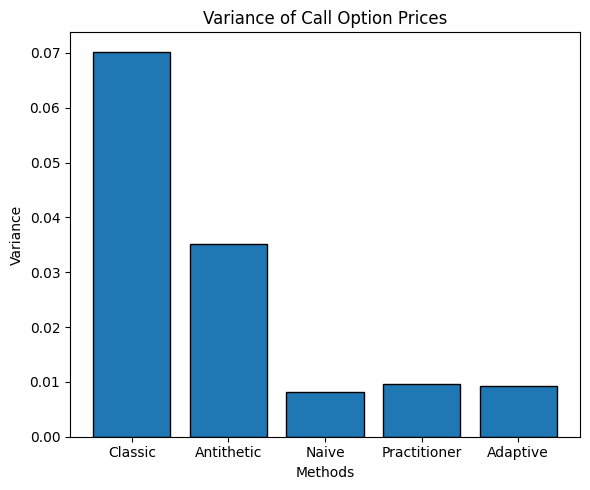

In [ ]:
plot_call_price_variance(methods, std)

100%|██████████| 30/30 [03:54<00:00,  7.82s/it]


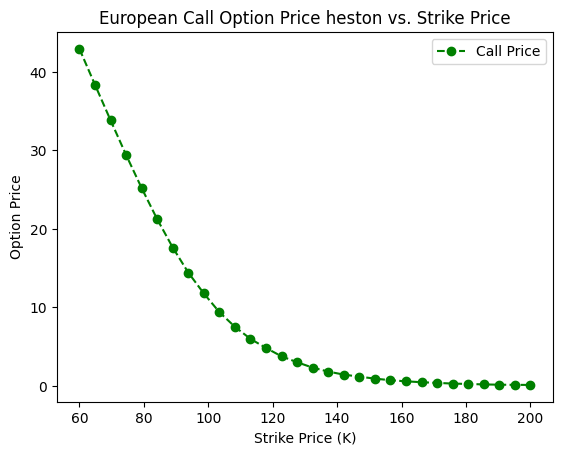

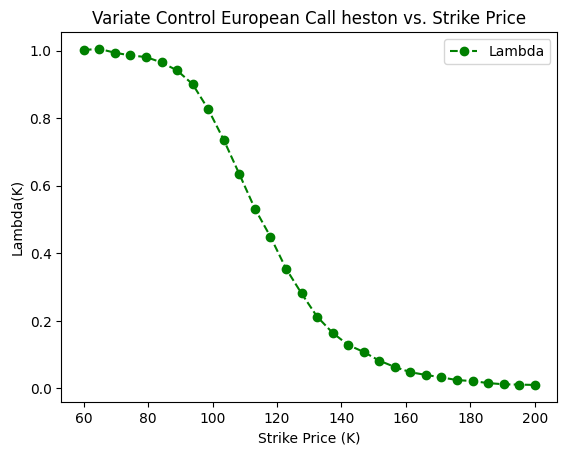

In [ ]:
plot_call_and_lambda_vs_K(asset=asset_,
                          n_simulations=n_simulations,
                          model='heston',
                          option_type='european',
                          K_min=60,
                          K_max=200,
                          num_points=30)

## Asian option with Heston model

In [ ]:
methods, prices, confidence_intervals, std = compute_call_prices_and_ci(asset=asset_, K=K, n_simulations=n_simulations, model='heston', option_type='asian')
display_results_as_dataframe(methods, prices, confidence_intervals)

,Method,Price,Confidence Interval
0,Classic,21.621995,0.091439
1,Antithetic,21.577488,0.045725
2,Naive,21.603472,0.006145
3,Practitioner,21.501894,0.011782
4,Adaptive,21.509698,0.010632


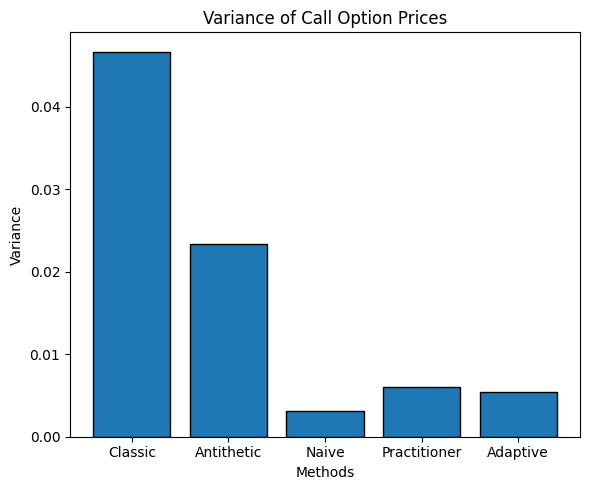

In [ ]:
plot_call_price_variance(methods, std)

100%|██████████| 30/30 [04:00<00:00,  8.01s/it]


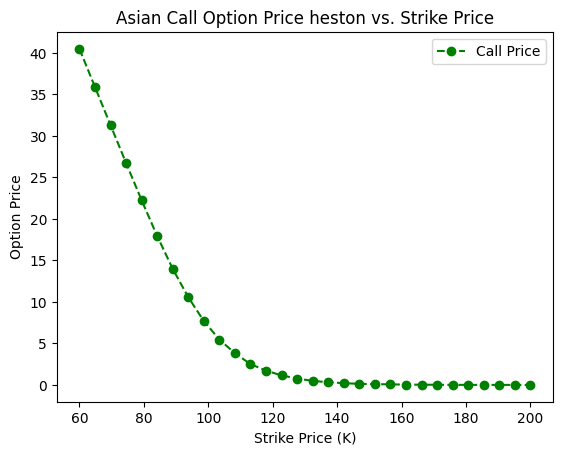

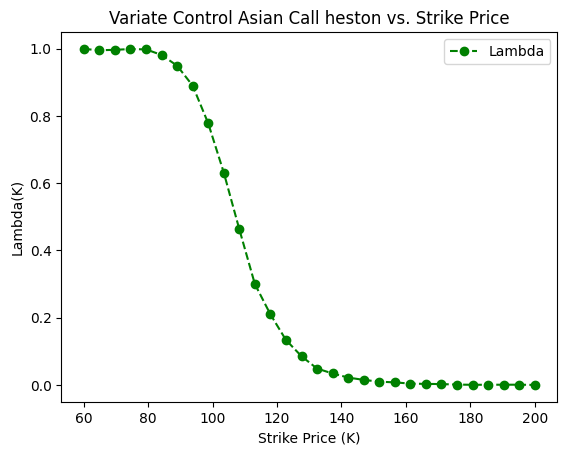

In [ ]:
plot_call_and_lambda_vs_K(asset=asset_,
                          n_simulations=n_simulations,
                          model='heston',
                          option_type='asian',
                          K_min=60,
                          K_max=200,
                          num_points=30)